# Occupazione della stanza | Classificazione

Iniziamo a fare gli import necessari, definiamo alcune funzioni che poi ci saranno utili e andiamo a recuperare i diversi file contenenti i dataset forniti (scegliamo di usare datatraining.txt e datatest.txt per fare training e un primo testing, andando a concatenarli, mentre useremo soltanto alla fine datatest2.txt per un'ulteriore validazione del lavoro svolto)

In [46]:
import pandas as pd
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import sklearn.metrics as sklearn_metrics
import seaborn as sns

# Funzione che prepara il dataset passato, andando a rendere le date del tipo corretto
# e ad aggiungere le feature "weekday" e "hour"
def prepare_dataset(dataset_to_prepare):
    dataset_to_prepare["date"] = pd.to_datetime(dataset_to_prepare["date"], errors='coerce')
    dataset_to_prepare["weekday"] = dataset_to_prepare["date"].dt.weekday
    dataset_to_prepare["hour"] = dataset_to_prepare["date"].dt.round('h').dt.hour
    dataset_to_prepare = dataset_to_prepare.drop("date", axis=1)
    return dataset_to_prepare

# Funzione che divide il dataset in un dataset di training e uno di testing,
# dividendo in due dataset, secondo il parametro training_ratio (compreso fra 0 e 1),
# mantenendo le proporzioni del dataset iniziale (andando a campionare una frazione
# fissa di ogni gruppo dell'etichetta di classificazione)
def subsample_dataset(input_dataset, training_ratio, classification_label):
    training_dataset = (input_dataset.groupby(classification_label, group_keys=False)
                        .sample(frac=training_ratio))
    testing_dataset = input_dataset[~input_dataset.index.isin(training_dataset.index)]
    return training_dataset, testing_dataset

# Funzione che divide le features dalla verità dei fatti
def get_x_y(input_dataset, label):
    y = input_dataset[label]
    x = input_dataset.drop(label, axis="columns")
    return x, y

SRC_DATASET = "./data/datatraining.txt"
SRC_DATASET_2 = "./data/datatest.txt"
FINAL_DATASET = "./data/datatest2.txt"

dataset = pd.read_csv(SRC_DATASET)
dataset2 = pd.read_csv(SRC_DATASET_2)
dataset = pd.concat([dataset, dataset2], ignore_index=True)

final_dataset = pd.read_csv(FINAL_DATASET)
dataset = prepare_dataset(dataset)
final_dataset = prepare_dataset(final_dataset)

Andiamo a fare il subsample del risultato dell'unione dei due files fatta al passo precedente, in modo da ottenere un dataset di training e uno di testing (teniamo da parte per ora datatest2.txt, in modo da poterlo usare in un secondo momento per validare ulteriormente quanto fatto).
Dividiamo anche le features dalla label corrispondente, ottenendo X e y, per entrambi gli insiemi.

In [ ]:
training, testing = subsample_dataset(dataset, training_ratio=0.75, classification_label="Occupancy")

X_train, y_train = get_x_y(training, "Occupancy")

X_test, y_test = get_x_y(testing, "Occupancy")

## Scelta degli iper-parametri

Dato che con `random_state` diversi, otteniamo iper-parametri "ottimali" leggermente diversi, andiamo calcolare gli iper-parametri "ottimali" su 50 `random_state` diversi (scegliamo questo numero essendo la grid search computazionalmente onerosa).
Quindi, calcoliamo la moda, in modo da ottenere gli iper-parametri più frequenti e quindi, probabilmente, i migliori in generale, per la nostra Random Forest.

In [11]:
NUM_TRIALS = 50

param_grid = {
        'n_estimators': [100, 200, 500],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 5],
        'max_samples': [0.5, 0.8, 1.0],
        'max_depth': [None, 10, 30]
    }

best_estimators_parameters = {
    'n_estimators': [],
    'min_samples_split': [],
    'min_samples_leaf': [],
    'max_samples': [],
    'max_depth': []
}

for i in range(NUM_TRIALS):
    rf = RandomForestClassifier(n_jobs=-1, random_state=i)

    grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5, n_jobs=-1) #usiamo 5-fold cross validation
    grid_search.fit(X_train, y_train)

    for param in grid_search.best_params_.keys():
        if param == 'max_depth' and grid_search.best_params_[param] is None:
            best_estimators_parameters[param].append(-1)
        else:
            best_estimators_parameters[param].append(grid_search.best_params_[param])

best_estimators_parameters = pd.DataFrame.from_dict(best_estimators_parameters)
best_estimators_parameters.to_csv("estimators_parameters.csv")
print(best_estimators_parameters)
print(best_estimators_parameters.mode())  #parametro 0 (default) si ottiene la moda per colonna


    n_estimators  min_samples_split  min_samples_leaf  max_samples  max_depth
0            500                  2                 1          0.5         -1
1            500                  2                 1          0.5         -1
2            200                  2                 1          0.5         -1
3            500                  2                 1          0.5         -1
4            500                  5                 1          1.0         -1
5            100                  2                 2          0.8         -1
6            500                  2                 1          0.5         -1
7            100                  5                 2          1.0         -1
8            500                  2                 1          0.5         -1
9            200                  2                 1          0.5         -1
10           200                  2                 1          0.5         -1
11           500                  5                 1          0

Ora che abbiamo la moda, vogliamo analizzare anche con quale frequenza si presenta ogni valore, per capire se abbiamo effettivamente fatto una scelta sensata: proviamo quindi a visualizzare la tabella stampata al passo precedente.

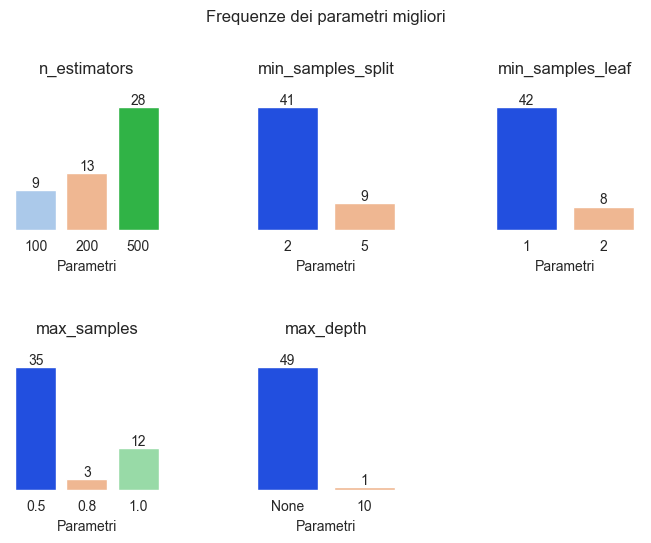

In [70]:
params = best_estimators_parameters.columns.tolist()
n = len(params)
cols = 3
rows = 2
fig, axes = plt.subplots(rows, cols, constrained_layout=True)
fig.set_constrained_layout_pads(hspace=0.2, wspace=0.4)
axes = axes.flatten()

for i, param in enumerate(params):
    ax = axes[i]
    counts = best_estimators_parameters[param].astype(str).value_counts().sort_index()
    counts.index = counts.index.to_series().replace("-1", "None")
    palette = sns.color_palette("pastel", n_colors=len(counts))
    palette[counts.values.argmax()] = sns.color_palette("bright")[counts.values.argmax()]
    sns.barplot(x=counts.index, y=counts.values, ax=ax, palette=palette, hue=counts.index)
    ax.set_title(param)
    ax.set_xlabel('Parametri')
    ax.set(yticklabels=[])
    ax.set_title(param, pad=20)

    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge')

    for spine in ax.spines.values():
        spine.set_visible(False)


for i in range(len(params), len(axes)):
    fig.delaxes(axes[i])


plt.suptitle('Frequenze dei parametri migliori', y=1.1)
plt.savefig("./plots/frequenze_parametri_migliori_50_grid_search.png", transparent=True)
plt.show()

Dalla visualizzazione appare evidente che gli iper-parametri corrispondenti alla moda sono i più comuni, con un buon distacco

Utilizzando quindi gli iper-parametri corrispondenti alle mode appena trovate e il training set, andiamo a fare il fitting del modello

In [ ]:
hyperparameters = best_estimators_parameters.mode()
max_depth = hyperparameters['max_depth'][0]

classifier_with_tuned_paramaters = RandomForestClassifier(
    n_jobs=-1, n_estimators=hyperparameters['n_estimators'][0],
    min_samples_split=hyperparameters['min_samples_split'][0],
    min_samples_leaf=hyperparameters['min_samples_leaf'][0],
    max_samples=hyperparameters['max_samples'][0],
    max_depth= None if max_depth == -1 else max_depth,
    random_state= 42
)

classifier_with_tuned_paramaters.fit(X_train, y_train)

## Testing e risultati

### Utilizzo del testing set realizzato da noi con subsampling stratificato
Ora andiamo a fare una predizione sul testing set e verifichiamo quali sono i risultati utilizzando:
- Matrice di confusione
- F1-score
- Recall
- Precision

In [ ]:
y_pred = classifier_with_tuned_paramaters.predict(X_test)

labels = classifier_with_tuned_paramaters.classes_

print(sklearn_metrics.classification_report(y_test, y_pred))
confusion_matrix = sklearn_metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predetto')
plt.ylabel('Vero')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig("./plots/confusion_matrix_training.png", transparent=True)
plt.show()

Calcoliamo anche la **ROC**, che ci permette di visualizzare come una curva le performance del modello al variare della soglia di decisione, mostrando per ogni valore il True Positive Rate e il False Positive Rate.
<br>
Dalla ROC ricaviamo anche l'**AUC-ROC**, ovvero l'area sotto alla curva ROC (l'integrale, essenzialmente), che ci permette di valutare il modello nel suo complesso, indipendentemente dalla soglia di decisione scelta.

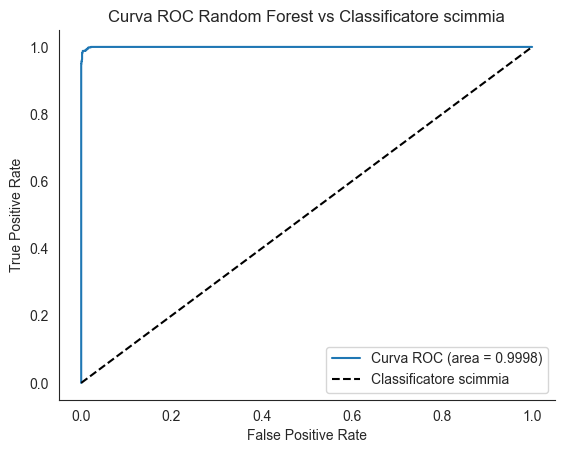

In [29]:
y_pred_proba = classifier_with_tuned_paramaters.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc_auc = roc_auc_score(y_test, y_pred_proba)

sns.set_style({'axes.grid' : False})

plt.plot(fpr, tpr, label="Curva ROC (area = %0.4f)" % roc_auc)
plt.plot([0, 1], [0, 1], "k--", label="Classificatore scimmia")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC Random Forest vs Classificatore scimmia')
plt.legend(loc="lower right")
sns.despine()
plt.savefig("./plots/roc_curve_training.png", transparent=True)
plt.show()

Vediamo sia dal grafico della ROC, che dal valore della ROC-AUC, che il classificatore outperforma, con grande distacco, il "classificatore scimmia" e che svolge un ottimo lavoro.

### Utilizzo di un testing test separato fornito dagli autori del dataset

Ripetiamo quanto fatto, infine, con il dataset contenuto nel file che avevamo lasciato da parte, in modo da ottenere un'ulteriore valutazione del modello, in modo da valutare il lavoro che abbiamo fatto ipotizzando (facciamo questo per "simulare" il comportamento del modello in un "real-world scenario")

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      7703
           1       0.97      1.00      0.98      2049

    accuracy                           0.99      9752
   macro avg       0.99      0.99      0.99      9752
weighted avg       0.99      0.99      0.99      9752



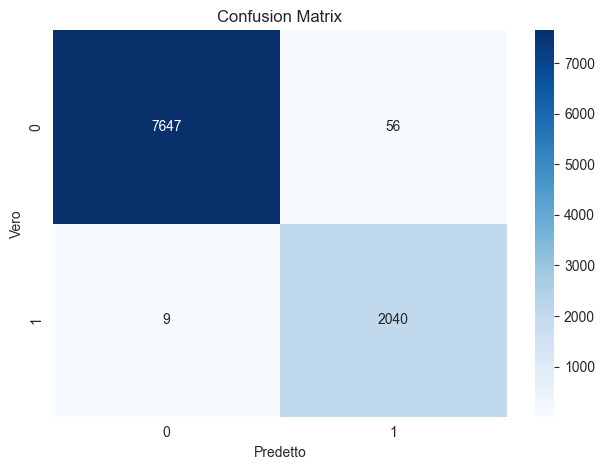

In [34]:
X_final_testing, y_final_testing = get_x_y(final_dataset, "Occupancy")

y_pred = classifier_with_tuned_paramaters.predict(X_final_testing)

confusion_matrix = sklearn_metrics.confusion_matrix(y_final_testing, y_pred)

print(sklearn_metrics.classification_report(y_final_testing, y_pred))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predetto')
plt.ylabel('Vero')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig("./plots/confusion_matrix_testing.png", transparent=True)
plt.show()

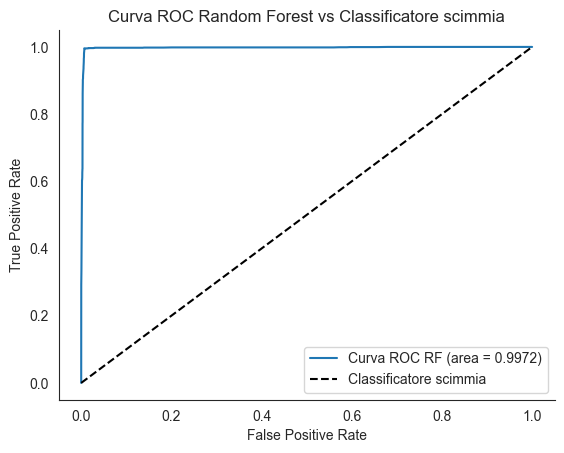

In [31]:
y_pred_proba = classifier_with_tuned_paramaters.predict_proba(X_final_testing)[:, 1]

fpr, tpr, thresholds = roc_curve(y_final_testing, y_pred_proba)

roc_auc = roc_auc_score(y_final_testing, y_pred_proba)

sns.set_style({'axes.grid' : False})

plt.plot(fpr, tpr, label="Curva ROC RF (area = %0.4f)" % roc_auc)
plt.plot([0, 1], [0, 1], "k--", label="Classificatore scimmia")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC Random Forest vs Classificatore scimmia')
plt.legend(loc="lower right")
sns.despine()
plt.savefig("./plots/roc_curve_testing.png", transparent=True)
plt.show()

Vediamo che tutti gli indici di performance sono in linea con quelli individuati in precedenza, cosa che sottolinea le buone performance del classificatore

## Importanza delle features nella Random Forest

Andiamo a vedere quanto sono risultate importanti le diverse features all'interno dei diversi alberi della nostra Random Forest (quindi quanto influiscono le varie features sul risultato della classificazione)

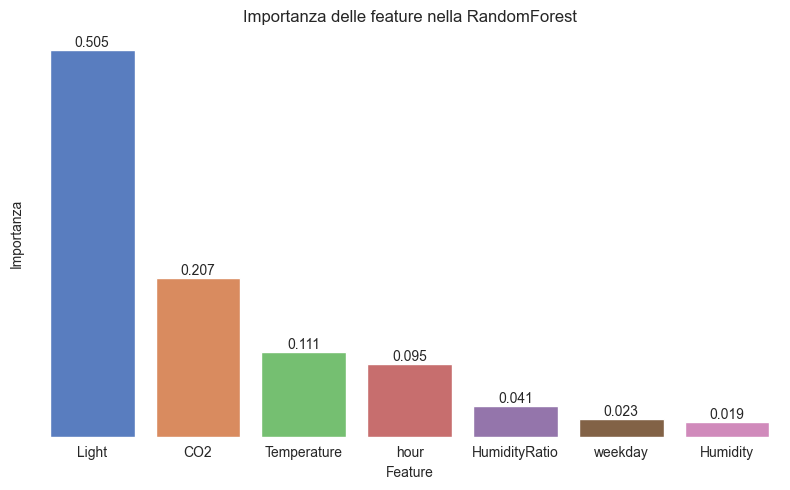

In [32]:
import pandas as pd

sns.set_style('white')

palette = sns.color_palette("muted", n_colors=len(classifier_with_tuned_paramaters.feature_importances_))
importances = pd.DataFrame({
    "Feature": X_train.columns,
    "Importanza": classifier_with_tuned_paramaters.feature_importances_
}).sort_values("Importanza", ascending=False)

plt.figure(figsize=(8, 5))

barplot = sns.barplot(data=importances, x="Feature", y="Importanza", palette=palette, hue="Feature")

barplot.set(yticklabels=[])

for container in barplot.containers:
    barplot.bar_label(container, fmt='%.3f', label_type='edge')

for spine in barplot.spines.values():
    spine.set_visible(False)

plt.title('Importanza delle feature nella RandomForest')
plt.tight_layout()
plt.savefig("./plots/feature_importances_random_forest.png", transparent=True)
plt.show()

## Esempio di un albero della Random Forest

Quello che abbiamo fatto fino ad ora può sembrare un po' astratto, ma effettivamente vengono costruiti degli alberi di decisione, vediamone uno per esempio:

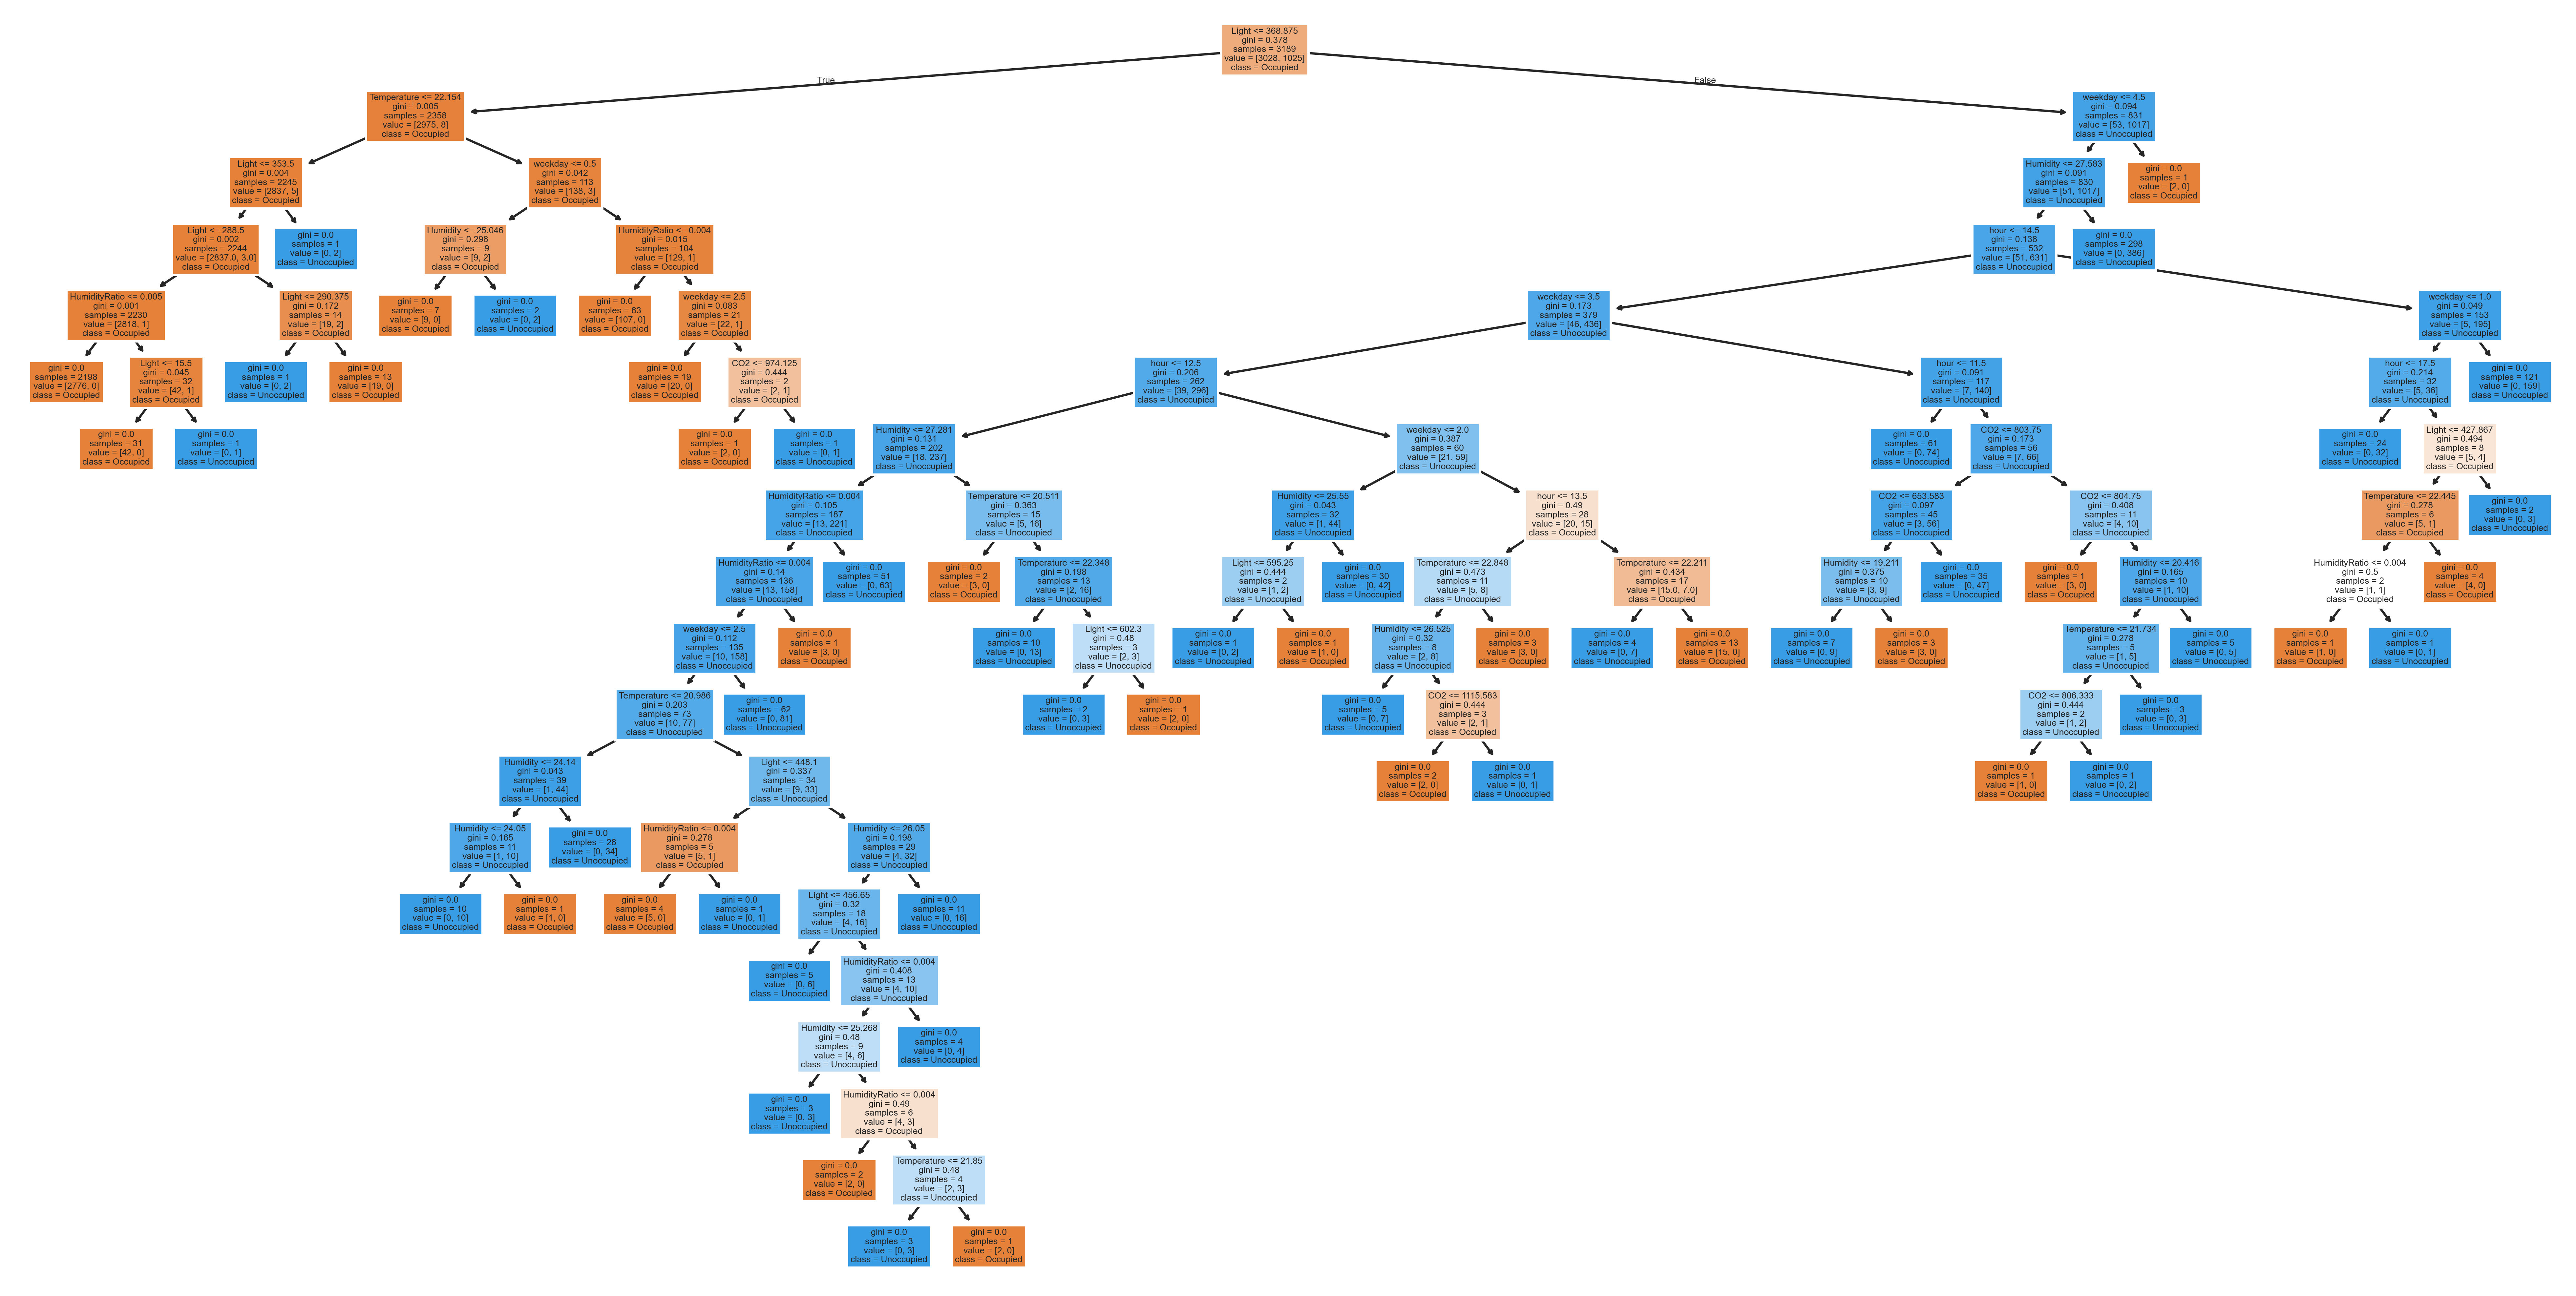

In [49]:
plt.figure(figsize=(20, 10), dpi=500)
plot_tree(classifier_with_tuned_paramaters.estimators_[424],
          feature_names=X_train.columns,
          class_names=["Occupied", "Unoccupied"],
          filled=True)
plt.savefig("./plots/tree_random_forest.png", transparent=True)
plt.show()